In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

sns.set()

In [79]:
# Extracción de datos

ratings = np.load('data/ratings.npy')
ratings_ = list()
for row in ratings:
    ratings_.append(row.split(','))
    
rates_df = pd.DataFrame(ratings_, columns=['user', 'movie_id', 'rate' ,'date'])
rates_df['date'] = pd.to_datetime(rates_df['date'])
rates_df['rate'] = rates_df['rate'].astype(int)

# Oscar's data
CATEGORY = 'BEST PICTURE'
MIN_YEAR = 2000

oscar_df = pd.read_csv('data/the_oscar_award.csv')
oscar_df = oscar_df[(oscar_df['category'] == CATEGORY) & (oscar_df['year_ceremony']>=MIN_YEAR)]
oscar_df['year_film'] = oscar_df['year_film'].astype(float)

# Movies info
movies_df = pd.read_csv('data/IMDB movies.csv')

# Movies ids
titles_basics = pd.read_csv('data/title_basics.tsv', sep='\t')
titles_basics = titles_basics.replace(r"\N", np.nan)
titles_basics['startYear'] = titles_basics['startYear'].astype(float)

E:\Usuarios\ahiguera\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
E:\Usuarios\ahiguera\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [80]:
movie_merge = pd.merge(oscar_df, titles_basics, left_on=['year_film', 'film'], right_on=['startYear', 'primaryTitle'])
movie_merge= movie_merge[movie_merge['titleType'] == 'movie']

In [81]:
movie_merge.groupby('film')['film'].count().sort_values()

film
12 Years a Slave                       1
The Descendants                        1
The Departed                           1
The Curious Case of Benjamin Button    1
The Cider House Rules                  1
                                      ..
Gravity                                1
Green Book                             1
Gangs of New York                      1
The Artist                             2
Spotlight                              2
Name: film, Length: 142, dtype: int64

In [1]:
# Nos quedamos con la pelicula correcta en el caso de hacer match por nombre y año con más de una pelicula
movie_merge.drop(index=[338, 161], inplace=True)

NameError: name 'movie_merge' is not defined

In [83]:
not_in_df = oscar_df[~oscar_df['film'].isin(movie_merge['film'])]

In [84]:
pelis_faltantes = {
    'Moulin Rouge' : 'tt0203009',
    'Crash' : 'tt0375679',
    'The Hurt Locker' : 'tt0887912',
    "Precious: Based on the Novel 'Push' by Sapphire" : 'tt0929632',
    'Three Billboards outside Ebbing, Missouri' : 'tt5027774',
    'Once upon a Time...in Hollywood' : 'tt7131622'
}

In [85]:
movie_merge = movie_merge[movie_merge.columns[:8]]

In [86]:
not_in_df['tconst'] = pelis_faltantes.values()

<ipython-input-86-dceaa9b7b4dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_in_df['tconst'] = pelis_faltantes.values()


In [87]:
oscar_movies= pd.concat([movie_merge, not_in_df]).reset_index(drop=True)

In [88]:
movies_columns = [  'imdb_title_id', 
                    'genre',
                    'duration',
                    'country',
                    'language',
                    'budget',
                    'avg_vote',
                    'votes',
                    'usa_gross_income',
                    'worlwide_gross_income',
                    'metascore'
                    ]
oscar_columns =[
                    'year_ceremony',
                    'film',
                    'winner',
                    'tconst'
]

In [89]:
data_df = pd.merge(oscar_movies[oscar_columns], movies_df[movies_columns], left_on='tconst', right_on='imdb_title_id')

In [90]:
# Armemos el data set con lo que tenemos:
# Hot encoding of genre
# duration
# hot encoding country
# hot encoding language
# budget
# usa_gross_income
# worldwide_gross_income
# metascore

def one_hot_encoding(df, column, as_int = True, drop_column = True):
    cat_rows = list()
    for cat in df[column].to_numpy():
        cat_rows.append(cat.split(', '))

    unique_cat = np.asarray( list( set().union(*cat_rows) ) )

    ohe = list()
    for row in cat_rows:
        ohe.append(np.isin(unique_cat, row))
    
    ohe_df = pd.DataFrame(ohe, columns=unique_cat)

    if as_int:
        ohe_df = ohe_df.astype(int)
    
    if drop_column:
        df.drop(columns=[column], inplace=True)
    return pd.merge(df, ohe_df, left_index=True, right_index=True)


In [91]:
data = one_hot_encoding(data_df, 'genre')
data = one_hot_encoding(data, 'language')
data = one_hot_encoding(data, 'country')

In [92]:
data['budget'] = data['budget'].str.extract('(\d+)').astype(float)
data['usa_gross_income'] = data['usa_gross_income'].str.extract('(\d+)').astype(float)
data['worlwide_gross_income'] = data['worlwide_gross_income'].str.extract('(\d+)').astype(float)

In [93]:
rates_df['year'] = rates_df['date'].dt.year

In [94]:
ceremony_date ={
    '2000' : '2000-03-26',
    '2001' : '2001-03-25',
    '2002' : '2002-03-24',
    '2003' : '2003-03-23',
    '2004': '2004-02-29',
    '2005' : '2005-02-27',
    '2006' : '2006-03-05',
    '2007' : '2007-02-25',
    '2008' : '2008-02-24',
    '2009' : '2009-02-22',
    '2010' : '2010-03-07',
    '2011' : '2011-02-27',
    '2012' : '2012-02-26',
    '2013' : '2013-02-24',
    '2014' : '2014-03-02',
    '2015' : '2015-02-22',
    '2016' : '2016-02-28',
    '2017' : '2017-02-26',
    '2018' : '2018-03-04',
    '2019' : '2019-02-24',
    '2020' : '2020-02-09'
}

In [95]:
rates = pd.merge(rates_df, data[['tconst', 'year_ceremony']], left_on='movie_id', right_on='tconst')
rates = rates[rates.apply(lambda x: x.date < pd.to_datetime(ceremony_date[str(x.year_ceremony)]), axis=1)]

In [96]:
rates_agg_df = rates.groupby('movie_id').agg(
    rate_avg = pd.NamedAgg(column="rate", aggfunc="mean"),
    num_rates = pd.NamedAgg(column='rate', aggfunc='count'),
    num_days = pd.NamedAgg(column= 'date', aggfunc='nunique'),
).reset_index(level=0)

In [97]:
data_set = pd.merge(data, rates_agg_df, left_on='tconst', right_on='movie_id')
data_set['winner'] = data_set['winner'].astype(int)
data_set.drop(columns=['movie_id'], inplace=True)

In [98]:
X = data_set.dropna()[data_set.columns[5:]].to_numpy()
Y = data_set.dropna()['winner'].to_numpy()

In [99]:
clf = RandomForestClassifier(n_estimators = 500, max_depth=7, max_features='sqrt')
clf.fit(X, Y)

RandomForestClassifier(max_depth=7, max_features='sqrt', n_estimators=500)

In [100]:
predictions = clf.predict(X)
acc = accuracy_score(Y,predictions)

Text(0.5, 39.5, '$Accuracy = 0.9653$')

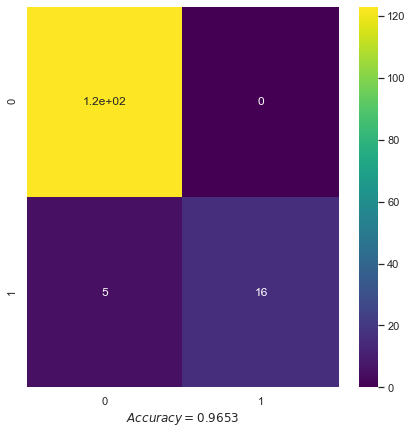

In [101]:
fig, axs = plt.subplots(1,1,figsize=(7,7))
sns.heatmap(confusion_matrix(Y, predictions), annot=True, ax=axs, cmap='viridis')
axs.set_xlabel(r'$Accuracy = {:.4f}$'.format(acc))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'votes'),
  Text(0, 1, 'metascore'),
  Text(0, 2, 'rate_avg'),
  Text(0, 3, 'avg_vote'),
  Text(0, 4, 'num_days'),
  Text(0, 5, 'budget'),
  Text(0, 6, 'num_rates'),
  Text(0, 7, 'worlwide_gross_income'),
  Text(0, 8, 'duration'),
  Text(0, 9, 'usa_gross_income'),
  Text(0, 10, 'Persian'),
  Text(0, 11, 'Belgium'),
  Text(0, 12, 'Korean'),
  Text(0, 13, 'Thriller'),
  Text(0, 14, 'Cantonese')])

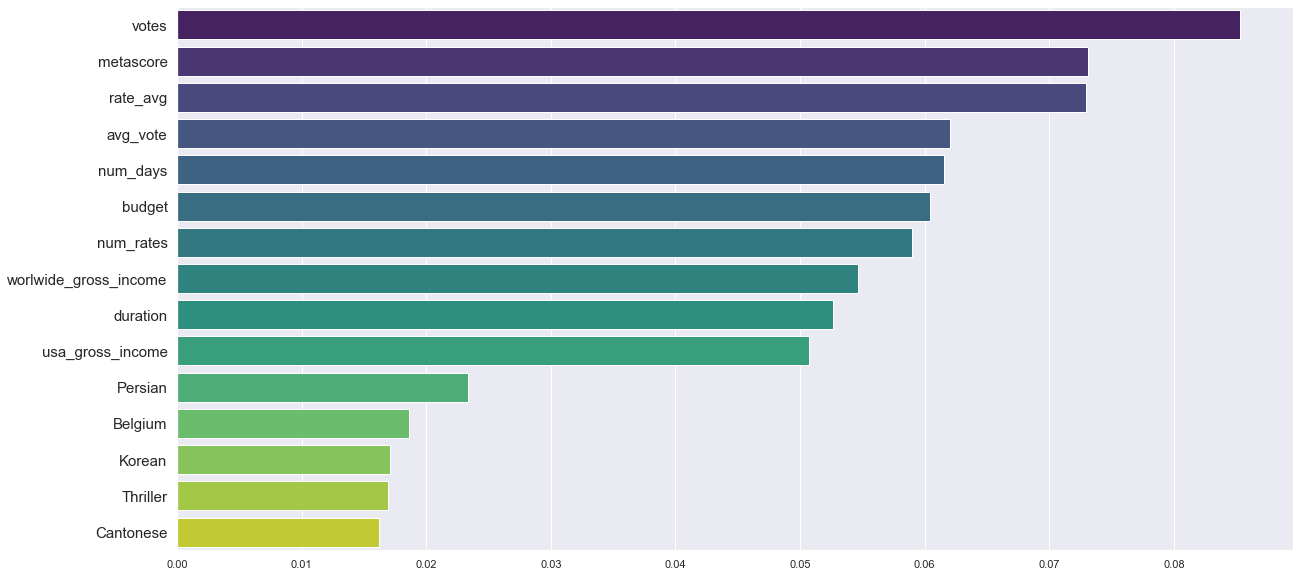

In [102]:
ft_ = pd.Series(clf.feature_importances_, index=data_set.columns[5:])
ft_.sort_values(ascending = False, inplace=True)
fig, axs = plt.subplots(1,1, figsize=(20,10))
sns.barplot(y=ft_.index[:15], x=ft_.values[:15], palette='viridis', ax=axs)
plt.xticks(rotation=0)
plt.yticks(fontsize=15)